In [60]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import re
from pathlib import Path

In [72]:
files = ["A_comp.csv", "B_comp.csv", "S_comp.csv"]
paths = []

for file in files:
    paths.append("/Users/thomasfish/Desktop/University_Work/II_Materials/P2_Plasticity/" + file)

A_df = pd.read_csv(paths[0], sep='\t', header=0)
B_df = pd.read_csv(paths[1], sep='\t', header=0)
S_df = pd.read_csv(paths[2], sep='\t', header=0)

A_df.columns

dfs = [A_df, B_df, S_df]
for df in dfs:
    for col in ["True Plastic Strain (-)", " True Stress (MPa)"]:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Calculated Youngs Moduli from initial linear portions of nominal stress-strain curves
E_Al = 99.625/0.0014438
E_Br = 96.468/0.00083866
E_St = 94.645/0.0004733
print(f"The calculated Young's modulus for Aluminum is {E_Al/1000:.2f} GPa")
print(f"The calculated Young's modulus for Brass is {E_Br/1000:.2f} GPa")
print(f"The calculated Young's modulus for Steel is {E_St/1000:.2f} GPa")

A_df["True Strain (-)"] =  (A_df["True Plastic Strain (-)"]/100 + (A_df[" True Stress (MPa)"] / E_Al))*100
B_df["True Strain (-)"] =  (B_df["True Plastic Strain (-)"]/100 + (B_df[" True Stress (MPa)"] / E_Br))*100
S_df["True Strain (-)"] =  (S_df["True Plastic Strain (-)"]/100 + (S_df[" True Stress (MPa)"] / E_St))*100

A_df["Nominal Strain (-)"] = (1 - (np.exp(-A_df["True Strain (-)"]/100)))*100
A_df["Nominal Stress (MPa)"] = A_df[" True Stress (MPa)"] / (1 - A_df["Nominal Strain (-)"]/100)
B_df["Nominal Strain (-)"] = (1 - (np.exp(-B_df["True Strain (-)"]/100)))*100
B_df["Nominal Stress (MPa)"] = B_df[" True Stress (MPa)"] / (1 - B_df["Nominal Strain (-)"]/100)
S_df["Nominal Strain (-)"] = (1 - (np.exp(-S_df["True Strain (-)"]/100)))*100
S_df["Nominal Stress (MPa)"] = S_df[" True Stress (MPa)"] / (1 - S_df["Nominal Strain (-)"]/100)

A_df.head(-10)

The calculated Young's modulus for Aluminum is 69.00 GPa
The calculated Young's modulus for Brass is 115.03 GPa
The calculated Young's modulus for Steel is 199.97 GPa


,True Plastic Strain (-),True Stress (MPa),True Strain (-),Nominal Strain (-),Nominal Stress (MPa)
0,0.000,249.062500,0.360950,0.360299,249.963116
1,0.001,251.970052,0.366164,0.365494,252.894366
2,0.002,254.830514,0.371309,0.370621,255.778482
3,0.003,257.644649,0.376388,0.375680,258.616219
4,0.004,260.413207,0.381400,0.380673,261.408319
...,...,...,...,...,...
1986,1.986,428.589216,2.607126,2.573434,439.910011
1987,1.987,428.589216,2.608126,2.574408,439.914410
1988,1.988,428.589216,2.609126,2.575383,439.918809
1989,1.989,428.589216,2.610126,2.576357,439.923208


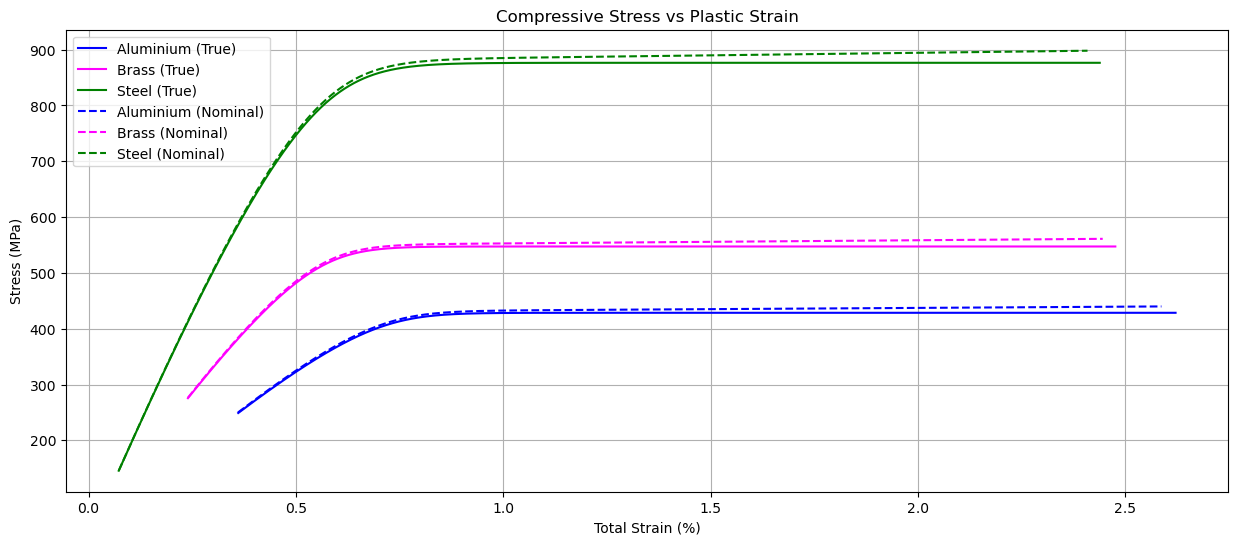

In [73]:
plt.figure(figsize=(15, 6))

plt.plot(A_df["True Strain (-)"], A_df[" True Stress (MPa)"], label="Aluminium (True)", color='blue')
plt.plot(B_df["True Strain (-)"], B_df[" True Stress (MPa)"], label="Brass (True)", color="magenta")
plt.plot(S_df["True Strain (-)"], S_df[" True Stress (MPa)"], label="Steel (True)", color="green")
plt.plot(A_df["Nominal Strain (-)"], A_df["Nominal Stress (MPa)"], label="Aluminium (Nominal)", linestyle='--', color='blue')
plt.plot(B_df["Nominal Strain (-)"], B_df["Nominal Stress (MPa)"], label="Brass (Nominal)", linestyle='--', color="magenta")
plt.plot(S_df["Nominal Strain (-)"], S_df["Nominal Stress (MPa)"], label="Steel (Nominal)", linestyle='--', color="green")

plt.xlabel("Total Strain (%)")
plt.ylabel("Stress (MPa)")
plt.title("Compressive Stress vs Plastic Strain")
plt.legend()
plt.grid(True)
base = Path("/Users/thomasfish/Desktop/University_Work/II_Materials/P2_Plasticity")
plt.savefig(base / "compressive_stress_strain.png", dpi=1000)
plt.show()

In [74]:
def voce(eps, sigma0, sigma_s, k):
    return sigma_s - (sigma_s - sigma0) * np.exp(-k * eps)

A_strain = A_df["True Plastic Strain (-)"].to_numpy()
A_stress = A_df[" True Stress (MPa)"].to_numpy()
B_strain = B_df["True Plastic Strain (-)"].to_numpy()
B_stress = B_df[" True Stress (MPa)"].to_numpy()
S_strain = S_df["True Plastic Strain (-)"].to_numpy()
S_stress = S_df[" True Stress (MPa)"].to_numpy()

A_p0 = [100, 200, 0.1]
B_p0 = [100, 200, 0.1]
S_p0 = [100, 200, 0.1]

A_params, A_cov = curve_fit(voce, A_strain, A_stress, p0=A_p0, maxfev=10000)
B_params, B_cov = curve_fit(voce, B_strain, B_stress, p0=B_p0, maxfev=10000)
S_params, S_cov = curve_fit(voce, S_strain, S_stress, p0=S_p0, maxfev=10000)
A_sigma0, A_sigma_s, A_k = A_params
B_sigma0, B_sigma_s, B_k = B_params
S_sigma0, S_sigma_s, S_k = S_params
print(f"Aluminium fitted parameters:\n  σ0 = {A_sigma0:.3f} MPa\n  σs = {A_sigma_s:.3f} MPa\n  k  = {A_k:.4f}")
print(f"Brass fitted parameters:\n  σ0 = {B_sigma0:.3f} MPa\n  σs = {B_sigma_s:.3f} MPa\n  k  = {B_k:.4f}")
print(f"Steel fitted parameters:\n  σ0 = {S_sigma0:.3f} MPa\n  σs = {S_sigma_s:.3f} MPa\n  k  = {S_k:.4f}")

A_strain_fit = np.linspace(A_strain.min(), A_strain.max(), 300)
A_stress_fit = voce(A_strain_fit, *A_params)
B_strain_fit = np.linspace(B_strain.min(), B_strain.max(), 300)
B_stress_fit = voce(B_strain_fit, *B_params)
S_strain_fit = np.linspace(S_strain.min(), S_strain.max(), 300)
S_stress_fit = voce(S_strain_fit, *S_params)

Aluminium fitted parameters:
  σ0 = 249.063 MPa
  σs = 428.589 MPa
  k  = 16.3282
Brass fitted parameters:
  σ0 = 275.625 MPa
  σs = 547.381 MPa
  k  = 17.5424
Steel fitted parameters:
  σ0 = 145.625 MPa
  σs = 876.500 MPa
  k  = 13.6477


/var/folders/r_/mmq2gnpx6qnbz26x3ypfrmvh0000gn/T/ipykernel_16314/3267223271.py:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(A_strain_fit, A_stress_fit, "r-", label="Aluminium Voce Fit", color='blue', linestyle='--')
/var/folders/r_/mmq2gnpx6qnbz26x3ypfrmvh0000gn/T/ipykernel_16314/3267223271.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(A_strain_fit, A_stress_fit, "r-", label="Aluminium Voce Fit", color='blue', linestyle='--')
/var/folders/r_/mmq2gnpx6qnbz26x3ypfrmvh0000gn/T/ipykernel_16314/3267223271.py:8: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(B_strain_fit, B_stress_fit, "r-", label="B

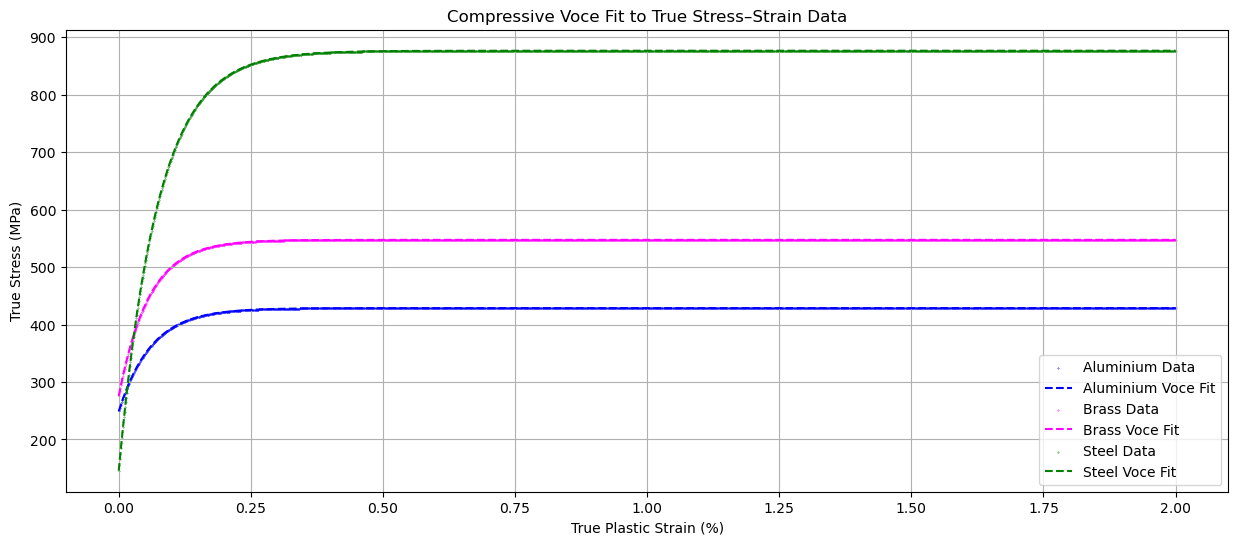

In [75]:
# Plot true stress data with the Voce curve fit

plt.figure(figsize=(15,6))

plt.scatter(A_strain, A_stress, s=0.1, label="Aluminium Data", color="blue", marker='o')
plt.plot(A_strain_fit, A_stress_fit, "r-", label="Aluminium Voce Fit", color='blue', linestyle='--')
plt.scatter(B_strain, B_stress, s=0.1, label="Brass Data", color="magenta", marker='o')
plt.plot(B_strain_fit, B_stress_fit, "r-", label="Brass Voce Fit", color='magenta', linestyle='--')
plt.scatter(S_strain, S_stress, s=0.1, label="Steel Data", color="green", marker='o')
plt.plot(S_strain_fit, S_stress_fit, "r-", label="Steel Voce Fit", color='green', linestyle='--')

plt.xlabel("True Plastic Strain (%)")
plt.ylabel("True Stress (MPa)")
plt.title("Compressive Voce Fit to True Stress–Strain Data")
plt.legend()
plt.grid(True)
base = Path("/Users/thomasfish/Desktop/University_Work/II_Materials/P2_Plasticity")
plt.savefig(base / "compressive_voce_fit+data.png", dpi=1000)
plt.show()